In [1]:
import math
import os
import warnings
from dataclasses import dataclass
from typing import Callable, List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import inspect

In [2]:
def apply_chunking_to_forward(
    forward_fn: Callable[..., torch.Tensor], chunk_size: int, chunk_dim: int, *input_tensors
) -> torch.Tensor:
    """
    This function chunks the `input_tensors` into smaller input tensor parts of size `chunk_size` over the dimension
    `chunk_dim`. It then applies a layer `forward_fn` to each chunk independently to save memory.
    If the `forward_fn` is independent across the `chunk_dim` this function will yield the same result as directly
    applying `forward_fn` to `input_tensors`.
    Args:
        forward_fn (`Callable[..., torch.Tensor]`):
            The forward function of the model.
        chunk_size (`int`):
            The chunk size of a chunked tensor: `num_chunks = len(input_tensors[0]) / chunk_size`.
        chunk_dim (`int`):
            The dimension over which the `input_tensors` should be chunked.
        input_tensors (`Tuple[torch.Tensor]`):
            The input tensors of `forward_fn` which will be chunked
    Returns:
        `torch.Tensor`: A tensor with the same shape as the `forward_fn` would have given if applied`.
    Examples:
    ```python
    # rename the usual forward() fn to forward_chunk()
    def forward_chunk(self, hidden_states):
        hidden_states = self.decoder(hidden_states)
        return hidden_states
    # implement a chunked forward function
    def forward(self, hidden_states):
        return apply_chunking_to_forward(self.forward_chunk, self.chunk_size_lm_head, self.seq_len_dim, hidden_states)
    ```"""

    assert len(input_tensors) > 0, f"{input_tensors} has to be a tuple/list of tensors"

    # inspect.signature exist since python 3.5 and is a python method -> no problem with backward compatibility
    num_args_in_forward_chunk_fn = len(inspect.signature(forward_fn).parameters)
    if num_args_in_forward_chunk_fn != len(input_tensors):
        raise ValueError(
            f"forward_chunk_fn expects {num_args_in_forward_chunk_fn} arguments, but only {len(input_tensors)} input "
            "tensors are given"
        )

    if chunk_size > 0:
        tensor_shape = input_tensors[0].shape[chunk_dim]
        for input_tensor in input_tensors:
            if input_tensor.shape[chunk_dim] != tensor_shape:
                raise ValueError(
                    f"All input tenors have to be of the same shape: {tensor_shape}, "
                    f"found shape {input_tensor.shape[chunk_dim]}"
                )

        if input_tensors[0].shape[chunk_dim] % chunk_size != 0:
            raise ValueError(
                f"The dimension to be chunked {input_tensors[0].shape[chunk_dim]} has to be a multiple of the chunk "
                f"size {chunk_size}"
            )

        num_chunks = input_tensors[0].shape[chunk_dim] // chunk_size

        # chunk input tensor into tuples
        input_tensors_chunks = tuple(input_tensor.chunk(num_chunks, dim=chunk_dim) for input_tensor in input_tensors)
        # apply forward fn to every tuple
        output_chunks = tuple(forward_fn(*input_tensors_chunk) for input_tensors_chunk in zip(*input_tensors_chunks))
        # concatenate output at same dimension
        return torch.cat(output_chunks, dim=chunk_dim)

    return forward_fn(*input_tensors)

In [3]:
class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self, hidden_size, max_position_embeddings, hidden_dropout_prob, type_vocab_size=2, layer_norm_eps=1e-12):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.token_type_embeddings = nn.Embedding(type_vocab_size, hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(hidden_dropout_prob)
        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.position_embedding_type = "absolute"
        self.register_buffer("position_ids", torch.arange(max_position_embeddings).expand((1, -1)))
        self.register_buffer(
            "token_type_ids", torch.zeros(self.position_ids.size(), dtype=torch.long), persistent=False
        )

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        past_key_values_length: int = 0,
    ) -> torch.Tensor:
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]

        # Setting the token_type_ids to the registered buffer in constructor where it is all zeros, which usually occurs
        # when its auto-generated, registered buffer helps users when tracing the model without passing token_type_ids, solves
        # issue #5664
        if token_type_ids is None:
            if hasattr(self, "token_type_ids"):
                buffered_token_type_ids = self.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(input_shape[0], seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = input_ids
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [4]:
class BertSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, position_embedding_type="relative_key", is_decoder=False):
        super().__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({hidden_size}) is not a multiple of the number of attention "
                f"heads ({num_attention_heads})"
            )

        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)
        self.position_embedding_type = position_embedding_type
        
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = is_decoder

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        use_cache = past_key_value is not None
        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                    -1, 1
                )
            else:
                position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r

            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

In [5]:
class BertSelfOutput(nn.Module):
    def __init__(self, hidden_size, hidden_dropout_prob, layer_norm_eps=1e-12):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [6]:
class BertAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, position_embedding_type):
        super().__init__()
        self.self = BertSelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob, position_embedding_type)
        self.output = BertSelfOutput(hidden_size, hidden_dropout_prob)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs

In [7]:
class BertIntermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size, hidden_act='gelu'):
        super().__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)
        
        if hidden_act == 'gelu':
            self.intermediate_act_fn = F.gelu

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

In [8]:
class BertOutput(nn.Module):
    def __init__(self, hidden_size, intermediate_size, hidden_dropout_prob, layer_norm_eps=1e-12):
        super().__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [9]:
class BertLayer(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, intermediate_size, attention_probs_dropout_prob, hidden_dropout_prob, add_cross_attention=False, chunk_size_feed_forward=0, is_decoder=False):
        super().__init__()
        self.chunk_size_feed_forward = chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BertAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob, position_embedding_type="relative_key")
        self.is_decoder = is_decoder
        self.add_cross_attention = add_cross_attention
        if self.add_cross_attention:
            if not self.is_decoder:
                raise ValueError(f"{self} should be used as a decoder model if cross attention is added")
            self.crossattention = BertAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob, position_embedding_type="absolute")
        self.intermediate = BertIntermediate(hidden_size, intermediate_size)
        self.output = BertOutput(hidden_size, intermediate_size, hidden_dropout_prob)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder:
            outputs = self_attention_outputs[1:-1]
            present_key_value = self_attention_outputs[-1]
        else:
            outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        cross_attn_present_key_value = None
        if self.is_decoder and encoder_hidden_states is not None:
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with cross-attention layers"
                    " by setting `config.add_cross_attention=True`"
                )

            # cross_attn cached key/values tuple is at positions 3,4 of past_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            cross_attention_outputs = self.crossattention(
                attention_output,
                attention_mask,
                head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                cross_attn_past_key_value,
                output_attentions,
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:-1]  # add cross attentions if we output attention weights

            # add cross-attn cache to positions 3,4 of present_key_value tuple
            cross_attn_present_key_value = cross_attention_outputs[-1]
            present_key_value = present_key_value + cross_attn_present_key_value

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        # if decoder, return the attn key/values as the last output
        if self.is_decoder:
            outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

In [10]:
class BertEncoder(nn.Module):
    def __init__(self, num_hidden_layers, hidden_size, num_attention_heads, intermediate_size, attention_probs_dropout_prob, hidden_dropout_prob, add_cross_attention=False, chunk_size_feed_forward=0, is_decoder=False):
        super().__init__()
        self.add_cross_attention = add_cross_attention
        self.layer = nn.ModuleList([BertLayer(hidden_size, num_attention_heads, intermediate_size, attention_probs_dropout_prob, hidden_dropout_prob, add_cross_attention=False, chunk_size_feed_forward=0, is_decoder=False) for _ in range(num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor]]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.add_cross_attention else None

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )

In [11]:
class BertPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [12]:
class BertPredictionHeadTransform(nn.Module):
    def __init__(self, hidden_size, hidden_act, layer_norm_eps=1e-12):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        if isinstance(hidden_act, str):
            self.transform_act_fn = ACT2FN[hidden_act]
        else:
            self.transform_act_fn = hidden_act
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

In [13]:
class BertLMPredictionHead(nn.Module):
    def __init__(self, hidden_size, hidden_act, vocab_size):
        super().__init__()
        self.transform = BertPredictionHeadTransform(hidden_size, hidden_act)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(hidden_size, vocab_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(vocab_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states


In [14]:
class BertOnlyMLMHead(nn.Module):
    def __init__(self, hidden_size, hidden_act, vocab_size):
        super().__init__()
        self.predictions = BertLMPredictionHead(hidden_size, hidden_act, vocab_size)

    def forward(self, sequence_output: torch.Tensor) -> torch.Tensor:
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


In [15]:
class BertOnlyNSPHead(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.seq_relationship = nn.Linear(hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score


In [16]:
class BertPreTrainingHeads(nn.Module):
    def __init__(self, hidden_size, hidden_act, vocab_size):
        super().__init__()
        self.predictions = BertLMPredictionHead(hidden_size, hidden_act, vocab_size)
        self.seq_relationship = nn.Linear(hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score

In [17]:
class BertModel(nn.Module):
    """
    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in [Attention is
    all you need](https://arxiv.org/abs/1706.03762) by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit,
    Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.
    To behave as an decoder the model needs to be initialized with the `is_decoder` argument of the configuration set
    to `True`. To be used in a Seq2Seq model, the model needs to initialized with both `is_decoder` argument and
    `add_cross_attention` set to `True`; an `encoder_hidden_states` is then expected as an input to the forward pass.
    """

    def __init__(self, num_hidden_layers, hidden_size, num_attention_heads, intermediate_size, attention_probs_dropout_prob, 
                 hidden_dropout_prob, type_vocab_size, max_position_embeddings, output_attentions, output_hidden_states, 
                 use_return_dict, use_cache, add_cross_attention=False, chunk_size_feed_forward=0, is_decoder=False, 
                 add_pooling_layer=True):
        super().__init__()
        
        self.is_decoder = is_decoder
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict
        self.use_cache = use_cache
        self.num_hidden_layers = num_hidden_layers

        self.embeddings = BertEmbeddings(hidden_size, max_position_embeddings, hidden_dropout_prob, type_vocab_size=2)
        self.encoder = BertEncoder(num_hidden_layers, hidden_size, num_attention_heads, intermediate_size, attention_probs_dropout_prob, 
                                   hidden_dropout_prob, add_cross_attention=False, chunk_size_feed_forward=0,is_decoder=False)

        self.pooler = BertPooler(hidden_size) if add_pooling_layer else None
        
        self.final_layer = nn.Linear(hidden_size, 1)

        # Initialize weights and apply final processing
        #self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor]]:
        r"""
        encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        if self.is_decoder:
            use_cache = use_cache if use_cache is not None else self.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape[0], input_shape[1]
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = None
        #extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = None
        #head_mask = self.get_head_mask(head_mask, self.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        sequence_output = torch.mean(sequence_output,dim=1,keepdim=False)
        sequence_output = self.final_layer(sequence_output)
        
        if return_dict:
            return (sequence_output, pooled_output)


In [18]:
# Define parameters for the model
num_hidden_layers = 2
hidden_size = 22
num_attention_heads = 2
intermediate_size = 44
attention_probs_dropout_prob = 0
hidden_dropout_prob = 0
type_vocab_size = 2
max_position_embeddings = 5000

# Create a BertModel instance
model = BertModel(num_hidden_layers, hidden_size, num_attention_heads, intermediate_size, attention_probs_dropout_prob, 
                  hidden_dropout_prob, type_vocab_size, max_position_embeddings, output_attentions=True, 
                  output_hidden_states=True, use_return_dict=True, use_cache=False, add_cross_attention=False, 
                  chunk_size_feed_forward=0, is_decoder=False, add_pooling_layer=True)

In [19]:
input_tensor = torch.rand(5, 20, 22)  # Your input tensor

In [20]:
sequence_output, pooled_output = model(input_ids=input_tensor)
print(sequence_output.shape)
print(sequence_output)

torch.Size([5, 1])
tensor([[0.7901],
        [0.8264],
        [0.7932],
        [0.8308],
        [0.7506]], grad_fn=<AddmmBackward0>)


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [22]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [23]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [24]:
df_for_training=df[feature_names].astype(float)

In [25]:
df_for_training.shape

(11524, 22)

In [26]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [27]:
trainX=[]
trainY=[]

In [28]:
n_future=1
n_past=20

In [29]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [30]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [31]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [32]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [33]:
data,label=random_shuffle(trainX,trainY)

In [34]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [35]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [36]:
label=standardization(label)

In [37]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
criterion = nn.L1Loss()

In [39]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        output, pooled_output = model(data)
       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.15124157071113586
Epoch: 1 Loss: 0.13404887914657593
Epoch: 2 Loss: 0.13116487860679626
Epoch: 3 Loss: 0.1296338587999344
Epoch: 4 Loss: 0.12866637110710144
Epoch: 5 Loss: 0.12830092012882233
Epoch: 6 Loss: 0.12833164632320404
Epoch: 7 Loss: 0.12865005433559418
Epoch: 8 Loss: 0.12919385731220245
Epoch: 9 Loss: 0.12937186658382416
Epoch: 10 Loss: 0.1291183978319168
Epoch: 11 Loss: 0.1286434680223465
Epoch: 12 Loss: 0.1277337521314621
Epoch: 13 Loss: 0.12765349447727203
Epoch: 14 Loss: 0.1273728907108307
Epoch: 15 Loss: 0.12705962359905243
Epoch: 16 Loss: 0.12556248903274536
Epoch: 17 Loss: 0.12493336200714111
Epoch: 18 Loss: 0.12655888497829437
Epoch: 19 Loss: 0.12657102942466736
Epoch: 20 Loss: 0.12597469985485077
Epoch: 21 Loss: 0.12546925246715546
Epoch: 22 Loss: 0.12534616887569427
Epoch: 23 Loss: 0.1253511756658554
Epoch: 24 Loss: 0.12477369606494904
Epoch: 25 Loss: 0.12477855384349823
Epoch: 26 Loss: 0.12492936849594116
Epoch: 27 Loss: 0.12456287443637848
Epoch: 2

Epoch: 225 Loss: 0.05780130997300148
Epoch: 226 Loss: 0.09080810844898224
Epoch: 227 Loss: 0.03874132037162781
Epoch: 228 Loss: 0.07125875353813171
Epoch: 229 Loss: 0.031722284853458405
Epoch: 230 Loss: 0.07624974846839905
Epoch: 231 Loss: 0.03289075195789337
Epoch: 232 Loss: 0.0719125047326088
Epoch: 233 Loss: 0.034402307122945786
Epoch: 234 Loss: 0.07196465879678726
Epoch: 235 Loss: 0.02602585032582283
Epoch: 236 Loss: 0.0715528354048729
Epoch: 237 Loss: 0.04930529370903969
Epoch: 238 Loss: 0.0386369489133358
Epoch: 239 Loss: 0.040823787450790405
Epoch: 240 Loss: 0.03685006499290466
Epoch: 241 Loss: 0.0694652572274208
Epoch: 242 Loss: 0.03265337273478508
Epoch: 243 Loss: 0.07090664654970169
Epoch: 244 Loss: 0.03344039246439934
Epoch: 245 Loss: 0.05966535955667496
Epoch: 246 Loss: 0.04528702050447464
Epoch: 247 Loss: 0.03271575644612312
Epoch: 248 Loss: 0.03676353394985199
Epoch: 249 Loss: 0.03883673623204231
Epoch: 250 Loss: 0.03850310668349266
Epoch: 251 Loss: 0.03960205614566803
Ep

Epoch: 444 Loss: 0.030757954344153404
Epoch: 445 Loss: 0.03273946791887283
Epoch: 446 Loss: 0.03179030865430832
Epoch: 447 Loss: 0.030042102560400963
Epoch: 448 Loss: 0.030390087515115738
Epoch: 449 Loss: 0.03230512514710426
Epoch: 450 Loss: 0.03265100717544556
Epoch: 451 Loss: 0.032407257705926895
Epoch: 452 Loss: 0.02829533815383911
Epoch: 453 Loss: 0.028710678219795227
Epoch: 454 Loss: 0.029080400243401527
Epoch: 455 Loss: 0.03348897770047188
Epoch: 456 Loss: 0.03223789110779762
Epoch: 457 Loss: 0.02925306372344494
Epoch: 458 Loss: 0.0328744538128376
Epoch: 459 Loss: 0.029820462688803673
Epoch: 460 Loss: 0.03014451637864113
Epoch: 461 Loss: 0.028213918209075928
Epoch: 462 Loss: 0.02894139662384987
Epoch: 463 Loss: 0.029370330274105072
Epoch: 464 Loss: 0.028133131563663483
Epoch: 465 Loss: 0.03158288449048996
Epoch: 466 Loss: 0.03270741179585457
Epoch: 467 Loss: 0.02974742278456688
Epoch: 468 Loss: 0.030219174921512604
Epoch: 469 Loss: 0.02926359698176384
Epoch: 470 Loss: 0.032405018

Epoch: 664 Loss: 0.02178412675857544
Epoch: 665 Loss: 0.03987623378634453
Epoch: 666 Loss: 0.02473713643848896
Epoch: 667 Loss: 0.03276003897190094
Epoch: 668 Loss: 0.021783899515867233
Epoch: 669 Loss: 0.038466453552246094
Epoch: 670 Loss: 0.02274296060204506
Epoch: 671 Loss: 0.03482864424586296
Epoch: 672 Loss: 0.022059250622987747
Epoch: 673 Loss: 0.04022247716784477
Epoch: 674 Loss: 0.023071695119142532
Epoch: 675 Loss: 0.03329117223620415
Epoch: 676 Loss: 0.02139599807560444
Epoch: 677 Loss: 0.04123956337571144
Epoch: 678 Loss: 0.023176994174718857
Epoch: 679 Loss: 0.03341330960392952
Epoch: 680 Loss: 0.02245483547449112
Epoch: 681 Loss: 0.03723796829581261
Epoch: 682 Loss: 0.021582992747426033
Epoch: 683 Loss: 0.032289523631334305
Epoch: 684 Loss: 0.020496271550655365
Epoch: 685 Loss: 0.03963698074221611
Epoch: 686 Loss: 0.023470621556043625
Epoch: 687 Loss: 0.03510063514113426
Epoch: 688 Loss: 0.022459350526332855
Epoch: 689 Loss: 0.03729592636227608
Epoch: 690 Loss: 0.022787403

Epoch: 883 Loss: 0.027276288717985153
Epoch: 884 Loss: 0.01890190690755844
Epoch: 885 Loss: 0.03208456188440323
Epoch: 886 Loss: 0.020501449704170227
Epoch: 887 Loss: 0.026896920055150986
Epoch: 888 Loss: 0.020798664540052414
Epoch: 889 Loss: 0.0347021259367466
Epoch: 890 Loss: 0.019406525418162346
Epoch: 891 Loss: 0.0263836607336998
Epoch: 892 Loss: 0.01752859354019165
Epoch: 893 Loss: 0.032543860375881195
Epoch: 894 Loss: 0.019384514540433884
Epoch: 895 Loss: 0.02627328224480152
Epoch: 896 Loss: 0.018178677186369896
Epoch: 897 Loss: 0.031458210200071335
Epoch: 898 Loss: 0.019017420709133148
Epoch: 899 Loss: 0.02740694023668766
Epoch: 900 Loss: 0.0192081481218338
Epoch: 901 Loss: 0.03239112347364426
Epoch: 902 Loss: 0.01913571171462536
Epoch: 903 Loss: 0.02713882550597191
Epoch: 904 Loss: 0.018323102965950966
Epoch: 905 Loss: 0.031419165432453156
Epoch: 906 Loss: 0.02062091790139675
Epoch: 907 Loss: 0.026411471888422966
Epoch: 908 Loss: 0.017438329756259918
Epoch: 909 Loss: 0.03196235

In [40]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [41]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [42]:
trainY_copy_=standardization(trainY_copy_)

In [43]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [44]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output, pooled_output=model(data)
    predictions+=output.tolist()

In [45]:
predictions = np.array(predictions)

In [46]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

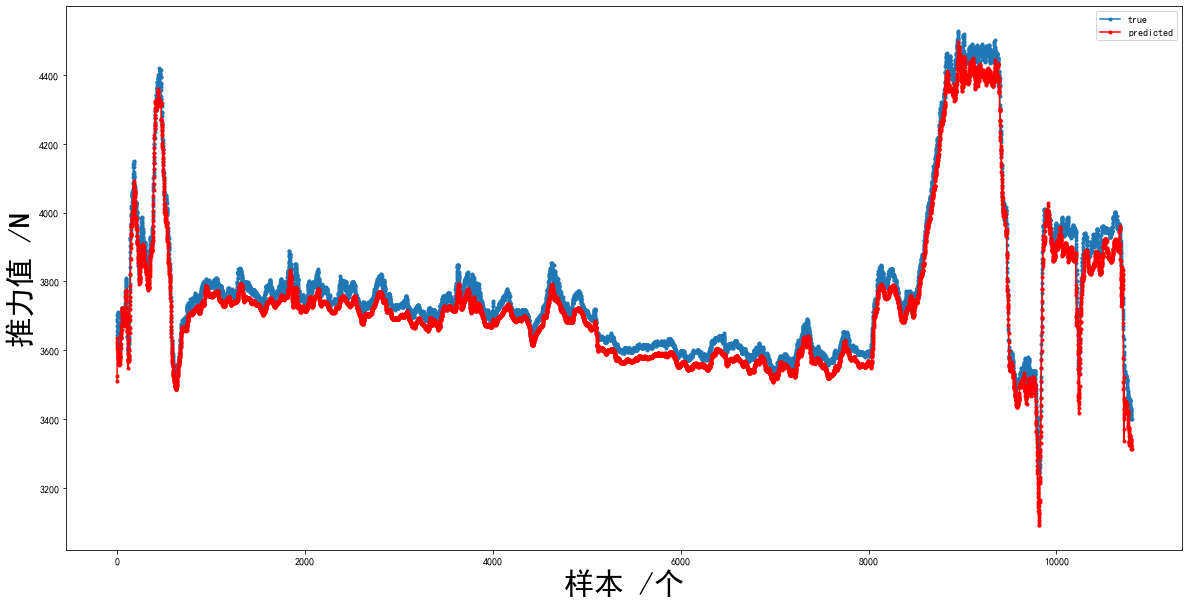

In [47]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 